决策树
与SVM一样，决策树也是一种多功能的机器学习算法，它可以
实现分类和回归任务，甚至是多输出任务。它们功能强大，能够拟合
复杂的数据集。

决策树同时也是随机森林（参见第7章）的基本组成部分，后者
是现今最强大的机器学习算法之一。

决策树训练和可视化

In [7]:
import os
import numpy as np
np.random.seed(42)


In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [9]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

要了解决策树，让我们先构建一个决策树，看看它是如何做出预
测的。下面的代码在鸢尾花数据集（见第4章）上训练了一个
DecisionTreeClassifier：

In [3]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [12]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=image_path("iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

FileNotFoundError: [Errno 2] No such file or directory: '.\\images\\decision_trees\\iris_tree.dot'

做出预测

决策树的特质之一就是它们需要的数据准备工作非常少。特
别是，完全不需要进行特征缩放或集中。

scikit-Learn使用的是CART算法，该算法仅生成二叉树：非
叶节点永远只有两个子节点（即问题答案仅有是或否）。但是，其他
算法，比如ID3生成的决策树，其节点可以拥有两个以上的子节点

估算类别概率

决策树同样可以估算某个实例属于特定类别k的概率：首先，跟
随决策树找到该实例的叶节点，然后返回该节点中类别k的训练实例
占比。例如，假设你发现一朵花，其花瓣长5厘米，宽1.5厘米。相应
的叶节点为深度2左侧节点，因此决策树输出如下概率：Setosa鸢尾
花，0%（0/54）；Versicolor鸢尾花，90.7%（49/54）；Virginica鸢尾
花，9.3%（5/54）。当然，如果你要求它预测类别，那么它应该输出
Versicolor鸢尾花（类别1），因为它的概率最高。我们试一下：

In [13]:
tree_clf.predict_proba([[5, 1.5]])


array([[ 0.        ,  0.90740741,  0.09259259]])

In [14]:
tree_clf.predict([[5, 1.5]])


array([1])

In [15]:
X[(X[:, 1]==X[:, 1][y==1].max()) & (y==1)] # widest Iris-Versicolor flower


array([[ 4.8,  1.8]])

In [16]:
not_widest_versicolor = (X[:, 1]!=1.8) | (y==2)
X_tweaked = X[not_widest_versicolor]
y_tweaked = y[not_widest_versicolor]

tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X_tweaked, y_tweaked)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=40,
            splitter='best')

In [18]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

上图显示了决策树的决策边界。加粗直线表示根节点（深度0）
的决策边界：花瓣长度=2.45厘米。因为左侧区域是纯的（只有Setosa
鸢尾花），所以它不可再分。但是右侧区域是不纯的，所以深度1右
侧的节点在花瓣宽度=1.75厘米处（虚线所示）再次分裂。因为这里
最大深度max_depth设置为2，所以决策树在此停止。但是如果你将
max_depth设置为3，那么两个深度为2的节点将各自再产生一条决策
边界（点线所示）。

如你所见，决策树是非常直观的，它们的决策也很容易解释，这
类模型通常被称为白盒模型。与之相反的，我们稍后将会看到，随机
森林或是神经网络被认为是一种黑盒模型。它们能做出很棒的预测，
你也可以轻松检查它们在做出预测时执行的计算，然而，通常很难解
释清楚它们为什么做出这样的预测。比如，如果神经网络说某个人出现在一张图片上，很难知道它实际上是基于什么做出的该预测：是模
型识别出来了这个人的眼睛？嘴巴？鼻子？还是鞋子？甚至是她坐的
沙发？相反，决策树提供了简单好用的分类规则，需要的话，你甚至
可以手动应用这些规则（例如，花的分类）。

CART训练算法
Scikit-Learn使用的是分类与回归树（Classification  And
Regression  Tree，简称CART）算法来训练决策树（也叫作“生
长”树）。想法非常简单：首先，使用单个特征k和阈值t k （例如，花
瓣长度≤2.45厘米）将训练集分成两个子集。k和阈值t k 怎么选择？答
案是产生出最纯子集（受其大小加权）的k和t k 就是经算法搜索确定的
（t，t k ）。

一旦成功将训练集一分为二，它将使用相同的逻辑，继续分裂子
集，然后是子集的子集，依次循环递进。直到抵达最大深度（由超参
数max_depth控制），或是再也找不到能够降低不纯度的分裂，它才
会停止。还有一些超参数（稍后介绍）可以用来控制附加的停止条件
（min_samples_split、min_samples_leaf、min_weight_fraction_leaf及
max_leaf_nodes）。

In [ ]:
CART是一种贪婪算法：从顶层开始搜索最优分
裂，然后每层重复这个过程。几层分裂之后，它并不会检视这个分裂
的不纯度是否为可能的最低值。贪婪算法通常会产生一个相当不错的
解，但是不能保证是最优解。

而不幸的是，寻找最优树是一个已知的NP完全问题： [1] 需要的时间是O（exp（m）），所以即使是很小的训练集，也相当棘手。这就
是为什么我们必须接受一个“相当不错”的解。

P就是能在多项式时间内解决的问题集。NP是能在多项式时间内
验证解正确与否的问题集。如果一个问题L是NP-Hard问题，那么任
意一个NP问题都可以在多项式时间内被规约成这个L问题。而NP完
全问题即是NP问题，又是NP-Hard问题。有一个数学开放问题，即P
是否等于NP？如果P≠NP（看起来很可能如此），那么对于任何NP完
全问题，将不存在多项式算法（可能量子计算机除外）。

计算复杂度
进行预测需要从根到叶遍历决策树。通常来说，决策树大致平
衡，因此遍历决策树需要经历大约O（log 2 （m））个节点。（注：
log 2 是以2为底的对数。等于log 2 （m）=log（m）/log（2）。）而每
个节点只需要检查一个特征值，所以总体预测复杂度也只是
O（log 2 （m）），与特征数量无关。如此，即便是处理大型数据集，
预测也很快。
但是，训练时在每一个节点，算法都需要在所有样本上比较所有
特征（如果设置了max_features会少一些）。这导致训练的复杂度为
O（n×m log（m））。对于小型训练集（几千个实例以内），Scikit-
Learn可以通过对数据预处理（设置presort=True）来加快训练，但是
对于较大训练集而言，可能会减慢训练的速度。

正则化超参数
决策树极少对训练数据做出假设（比如线性模型就正好相反，它
显然假设数据是线性的）。如果不加以限制，树的结构将跟随训练集
变化，严密拟合，并且很可能过度拟合。这种模型通常被称为非参数
模型，这不是说它不包含任何参数（事实上它通常有很多参数），而
是指在训练之前没有确定参数的数量，导致模型结构自由而紧密地贴
近数据。相应的参数模型，比如线性模型，则有预先设定好的一部分
参数，因此其自由度受限，从而降低了过度拟合的风险（但是增加了
拟合不足的风险）。
为避免过度拟合，需要在训练过程中降低决策树的自由度。现在
你应该知道，这个过程被称为正则化。正则化超参数的选择取决于你
所使用的模型，但是通常来说，至少可以限制决策树的最大深度。在
Scikit-Learn中，这由超参数max_depth控制（默认值为None，意味着
无限制）。减小max_depth可使模型正则化，从而降低过度拟合的风
险。
DecisionTreeClassifier类还有一些其他的参数，同样可以限制决
策树的形状：min_samples_split（分裂前节点必须有的最小样本
数），min_samples_leaf（叶节点必须有的最小样本数量），
min_weight_fraction_leaf（跟min_samples_leaf一样，但表现为加权实
例总数的占比），max_leaf_nodes（最大叶节点数量），以及
max_features（分裂每个节点评估的最大特征数量）。增大超参数
min_*或是减小max_*将使模型正则化

还可以先不加约束地训练模型，然后再对不必要的节点进行
剪枝（删除）。如果一个节点的子节点全部为叶节点，则该节点可被
认为不必要，除非它所表示的纯度提升有重要的统计意义。标准统计
测试，比如χ 2 测试，是用来估算“提升纯粹是出于偶然”（被称为虚假
设）的概率。如果这个概率（称之为p值）高于一个给定阈值（通常
是5%，由超参数控制），那么这个节点可被认为不必要，其子节点
可被删除。直到所有不必要的节点都被删除，剪枝过程结束。

G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


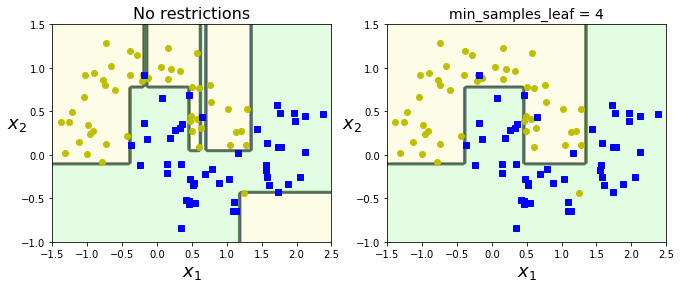

In [20]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

# save_fig("min_samples_leaf_plot")
'''
使用min_samples_leaf正则化
'''
plt.show()

G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


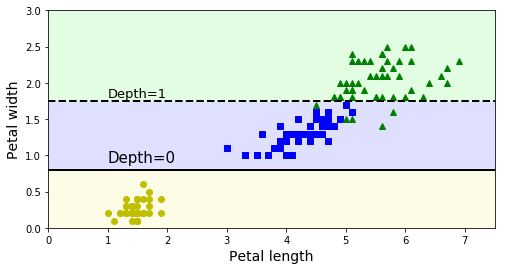

In [28]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X_tweaked, y_tweaked, legend=False)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

# save_fig("decision_tree_instability_plot")
plt.show()

更概括地说，决策树的主要问题是它们对训练数据中的小变化非
常敏感。例如，如果你从鸢尾花数据集中移除花瓣最宽的Versicolor
鸢尾花（花瓣长4.8厘米，宽1.8厘米），然后重新训练一个决策树，
你可能得到如上图所示的模型。这跟之前的决策树看起来截然
不同。事实上，由于Scikit-Learn所使用的算法是随机的， [1] 即使是在
相同的训练数据上，你也可能得到完全不同的模型（除非你对超参数
random_state进行设置）

上图显示了在卫星数据集（见第5章介绍）上训练的两个决策
树。左图使用默认参数（即无约束）来训练决策树，右图的决策树应
用min_samples_leaf=4进行训练。很明显，左图模型过度拟合，右图
的泛化效果更佳。

G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


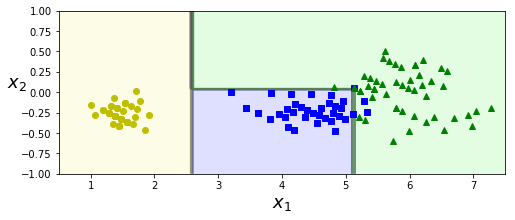

In [21]:
angle = np.pi / 180 * 20
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xr = X.dot(rotation_matrix)

tree_clf_r = DecisionTreeClassifier(random_state=42)
tree_clf_r.fit(Xr, y)

plt.figure(figsize=(8, 3))
plot_decision_boundary(tree_clf_r, Xr, y, axes=[0.5, 7.5, -1.0, 1], iris=False)

plt.show()

不稳定性
希望现在，你已经确信了选择决策树的充足理由：它们很容易理
解和解释，使用简单，功能全面并且十分强大。但是，它们确实也有
一些限制。首先，你可能已经注意到，决策树青睐正交的决策边界
（所有的分裂都与轴线垂直），这导致它们对训练集的旋转非常敏
感。

例如，下图显示了一个简单的线性可分离数据集：左图里，决
策树可以很轻松分裂；而到了右边，数据集旋转45°后，决策边界产
生了不必要的卷曲。虽然两个模型都看似完美拟合训练集，但是右侧
模型很可能泛化不佳。限制这种问题的方法之一是使用PCA（参见第
8章），让训练数据定位在一个更好的方向上。

G:\the_NEW_anaconda\lib\site-packages\matplotlib\contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


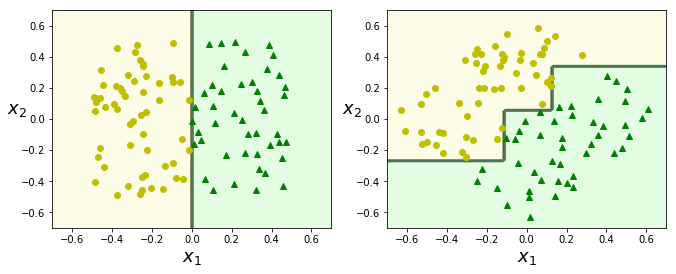

In [22]:
np.random.seed(6)
Xs = np.random.rand(100, 2) - 0.5
ys = (Xs[:, 0] > 0).astype(np.float32) * 2

angle = np.pi / 4
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
Xsr = Xs.dot(rotation_matrix)

tree_clf_s = DecisionTreeClassifier(random_state=42)
tree_clf_s.fit(Xs, ys)
tree_clf_sr = DecisionTreeClassifier(random_state=42)
tree_clf_sr.fit(Xsr, ys)

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree_clf_s, Xs, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)
plt.subplot(122)
plot_decision_boundary(tree_clf_sr, Xsr, ys, axes=[-0.7, 0.7, -0.7, 0.7], iris=False)

# save_fig("sensitivity_to_rotation_plot")
'''
对数据旋转敏感

'''
plt.show()

回归
决策树也可以执行回归任务。我们用Scikit_Learn的
DecisionTreeRegressor来构建一个回归树，在一个带噪声的二次数据
集上进行训练，其中max_depth=2：

In [23]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

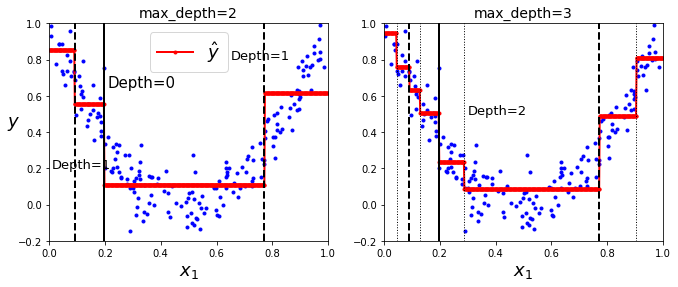

In [25]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

# save_fig("tree_regression_plot")
'''
两个决策树回归模型的预测对比
'''
plt.show()

上图的左侧显示了该模型的预测。如果设置max_depth=3，将得到如右图所示的预测。注意看，每个区域的预测值永远等于该区域内
实例的目标平均值。算法分裂每个区域的方法，就是使最多的训练实
例尽可能接近这个预测值。

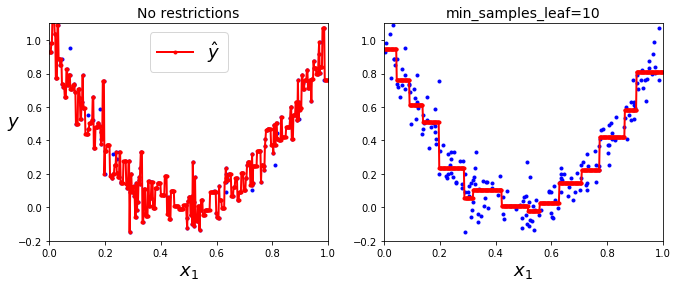

In [26]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.subplot(122)
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

# save_fig("tree_regression_regularization_plot")
'''

对回归决策树正则化
'''
plt.show()

与分类任务一样，决策树在处理回归任务时也很容易过度拟合。
如果没有任何正则化（即使用默认超参数），你将得到如上图左侧
所示的预测结果，这显然对训练集严重过度拟合。只需要设置
min_samples_leaf=10，就能得到一个看起来合理得多的模型，如右图所示。